In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm


In [2]:

if torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

mps


In [3]:
path = "images/birds.png"
im = Image.open(path).convert("RGB")
im_tensor_cpu = to_tensor(im).to(device="cpu")
im_tensor_mps =to_tensor(im).to(device="mps") 
print(f"inital tensor size : {im_tensor_cpu.shape}")


max_dim = 250
_, H, W = im_tensor_mps.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_mps.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0) *2 -1

print(f"rescaled tensor size : {im_resized.shape}")

inital tensor size : torch.Size([3, 164, 244])
rescaled tensor size : torch.Size([3, 168, 249])


In [4]:
min_dim = 25            # dimension mini au coarse scale
N = 0
current_H, current_W = new_H, new_W
r = 4 / 3               # scaling factor (environ 1.333)

# Calculer N tel que le coarse scale soit >= min_dim
while current_H >= min_dim and current_W >= min_dim:
    N += 1
    current_H = int(current_H / r)
    current_W = int(current_W / r)
N

7

In [5]:
scales = [im_resized.unsqueeze(0)]    # niveau 0 = fine

for i in range(0, N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / r), 1)
    new_w = max(int(w / r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


Number of scales N = 7
Scaling factor r = 1.333
Scale 0 : torch.Size([1, 3, 168, 249])


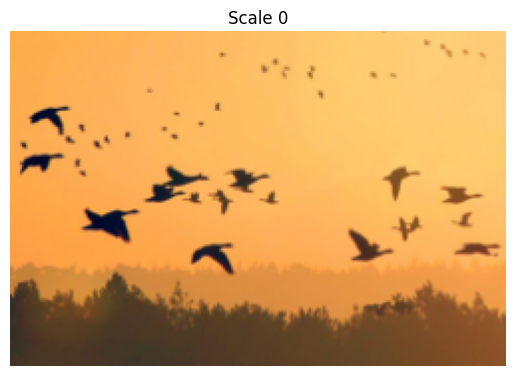

Scale 1 : torch.Size([1, 3, 126, 186])


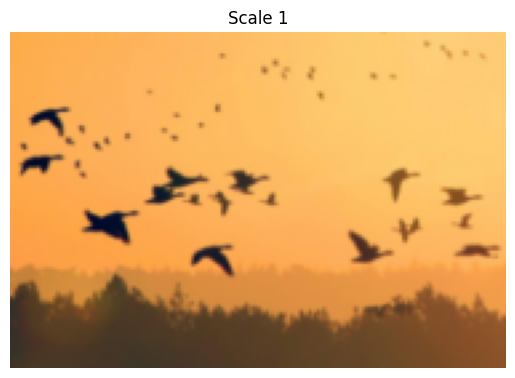

Scale 2 : torch.Size([1, 3, 94, 139])


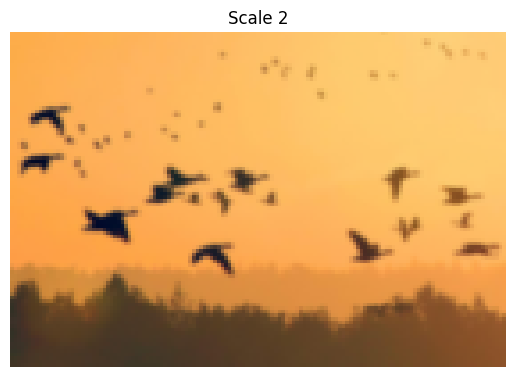

Scale 3 : torch.Size([1, 3, 70, 104])


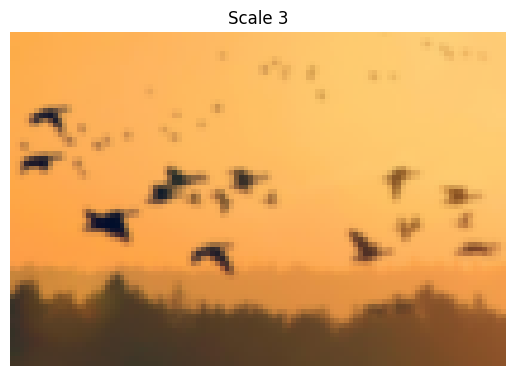

Scale 4 : torch.Size([1, 3, 52, 78])


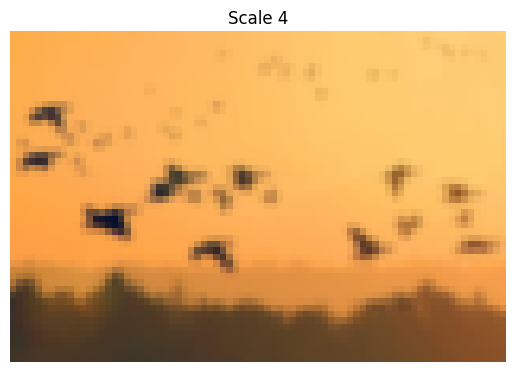

Scale 5 : torch.Size([1, 3, 39, 58])


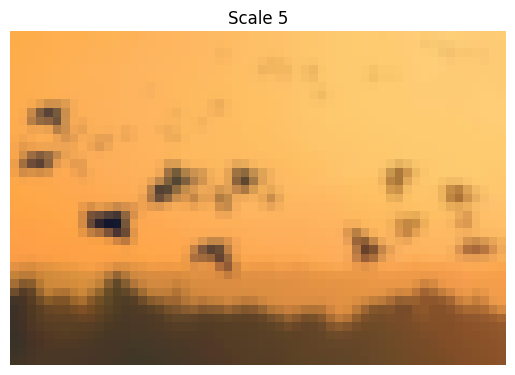

Scale 6 : torch.Size([1, 3, 29, 43])


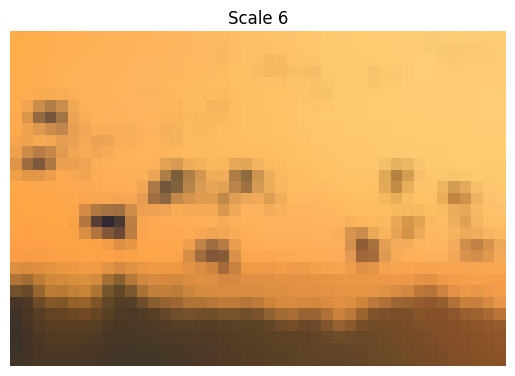

Scale 7 : torch.Size([1, 3, 21, 32])


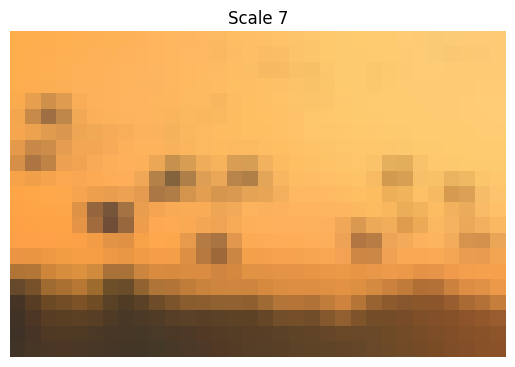

In [6]:
def pil_from_minus1to1(t):
    """
    Convertit un tenseur [-1,1] (CHW ou 1,C,H,W) en PIL Image.
    """
    t = t.squeeze(0) if t.dim() == 4 else t          # B×C×H×W → C×H×W
    t = ((t.clamp(-1, 1) + 1) / 2)                   # [-1,1] → [0,1]
    return to_pil_image(t.cpu())



print(f"Number of scales N = {N}")
print(f"Scaling factor r = {r:.3f}")
for i, im_scale in enumerate(scales):
    print(f"Scale {i} : {im_scale.shape}")
    plt.imshow(pil_from_minus1to1(im_scale.squeeze().cpu()))
    plt.axis('off')
    plt.title(f"Scale {i}")
    plt.show()


In [7]:
class Generator(nn.Module):
    
    def __init__(self,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.n_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            # Last conv layer outputs 3 channels (RGB), no batchnorm or activation
            nn.Conv2d(self.n_hidden, 3, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self,input):
        return self.main(input)

In [8]:
class Discriminator(nn.Module):
    def __init__(self,n_hidden):
        
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(3, self.n_hidden, kernel_size=3, padding=1),  
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, 1, 3, padding=1)  
        )
    
    def forward(self,input):
        return self.main(input)

In [9]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
             Tanh-14        [-1, 3, 102

In [10]:
netD_visu = Discriminator(n_hidden=32).to("cpu")
torchsummary.summary(netD_visu, input_size=input_size_visu,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 1, 1024, 1024]             289
Total params: 29,185
Trainable params: 

+ Générations des generateurs/discriminateurs

In [ ]:
hidden_lowest_dim = 32
Genarators = []
Discriminators = []

for i in range(len(scales)):
    u = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(u//4)).to(device))
    Discriminators.append(Discriminator(hidden_lowest_dim * 2**(u//4)).to(device))
    
Genarators.reverse()
Discriminators.reverse()

for gen in Genarators : 
     print(gen.n_hidden)
for dis in Discriminators:
     print(dis.n_hidden)


32
32
32
64
64
64
64
128
32
32
32
64
64
64
64
128


+ Boucle d'entrainement 

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)




it scale 7:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 7 | it 0]  Lips ≈ 0.07
[scale 7 | it 0]  LR = 5.00e-04


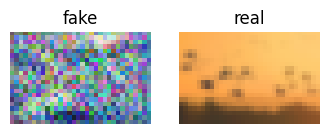

it scale 7:  10%|█         | 200/2000 [00:22<03:13,  9.32it/s]

[scale 7 | it 200]  Lips ≈ 1.09
[scale 7 | it 200]  LR = 5.00e-04


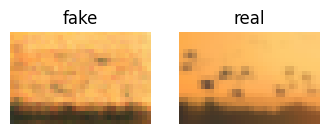

it scale 7:  20%|██        | 400/2000 [00:43<02:45,  9.67it/s]

[scale 7 | it 400]  Lips ≈ 1.24
[scale 7 | it 400]  LR = 5.00e-04


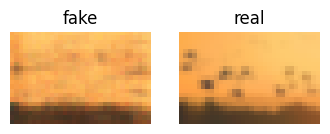

it scale 7:  30%|███       | 600/2000 [01:04<02:23,  9.73it/s]

[scale 7 | it 600]  Lips ≈ 1.38
[scale 7 | it 600]  LR = 5.00e-04


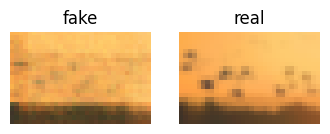

it scale 7:  40%|████      | 800/2000 [01:25<02:12,  9.04it/s]

[scale 7 | it 800]  Lips ≈ 1.24
[scale 7 | it 800]  LR = 5.00e-04


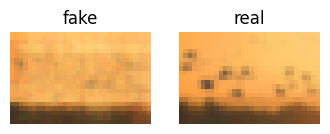

it scale 7:  50%|█████     | 1000/2000 [01:46<01:42,  9.73it/s]

[scale 7 | it 1000]  Lips ≈ 1.29
[scale 7 | it 1000]  LR = 5.00e-04


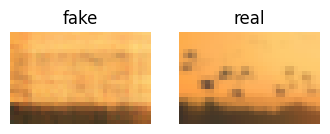

it scale 7:  60%|██████    | 1200/2000 [02:07<01:24,  9.49it/s]

[scale 7 | it 1200]  Lips ≈ 1.43
[scale 7 | it 1200]  LR = 5.00e-04


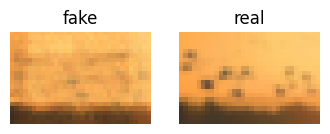

it scale 7:  70%|███████   | 1400/2000 [02:28<01:01,  9.75it/s]

[scale 7 | it 1400]  Lips ≈ 1.49
[scale 7 | it 1400]  LR = 5.00e-04


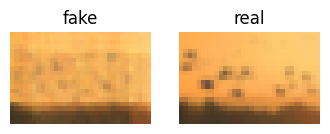

it scale 7:  80%|████████  | 1600/2000 [02:49<00:41,  9.76it/s]

[scale 7 | it 1600]  Lips ≈ 1.07
[scale 7 | it 1600]  LR = 5.00e-05


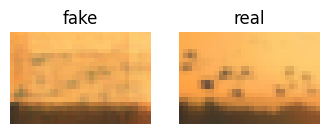

it scale 7:  90%|█████████ | 1800/2000 [03:10<00:20,  9.72it/s]

[scale 7 | it 1800]  Lips ≈ 1.30
[scale 7 | it 1800]  LR = 5.00e-05


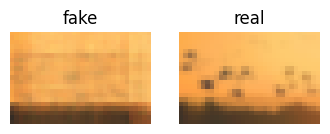

it scale 7: 100%|█████████▉| 1999/2000 [03:31<00:00,  9.47it/s]

[scale 7 | it 1999]  Lips ≈ 1.34
[scale 7 | it 1999]  LR = 5.00e-05


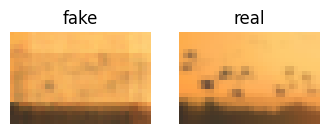

it scale 6:   0%|          | 0/2000 [00:00<?, ?it/s]           

[scale 6 | it 0]  Lips ≈ 0.03
[scale 6 | it 0]  LR = 5.00e-04


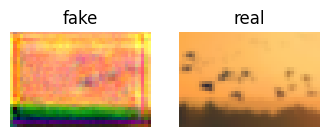

it scale 6:  10%|█         | 200/2000 [00:22<03:11,  9.40it/s]

[scale 6 | it 200]  Lips ≈ 1.06
[scale 6 | it 200]  LR = 5.00e-04


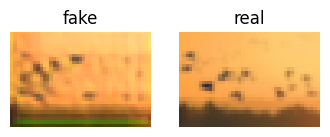

it scale 6:  20%|██        | 400/2000 [00:44<02:57,  8.99it/s]

[scale 6 | it 400]  Lips ≈ 1.10
[scale 6 | it 400]  LR = 5.00e-04


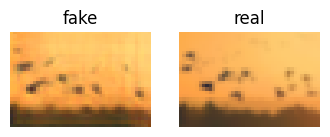

it scale 6:  30%|███       | 600/2000 [01:06<02:26,  9.58it/s]

[scale 6 | it 600]  Lips ≈ 1.14
[scale 6 | it 600]  LR = 5.00e-04


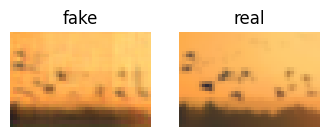

it scale 6:  40%|████      | 800/2000 [01:27<02:07,  9.42it/s]

[scale 6 | it 800]  Lips ≈ 1.13
[scale 6 | it 800]  LR = 5.00e-04


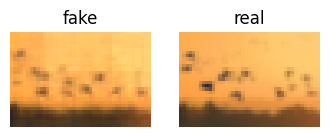

it scale 6:  50%|█████     | 1000/2000 [01:49<01:45,  9.49it/s]

[scale 6 | it 1000]  Lips ≈ 1.11
[scale 6 | it 1000]  LR = 5.00e-04


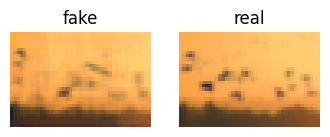

it scale 6:  60%|██████    | 1200/2000 [02:10<01:24,  9.51it/s]

[scale 6 | it 1200]  Lips ≈ 1.07
[scale 6 | it 1200]  LR = 5.00e-04


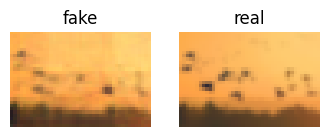

it scale 6:  70%|███████   | 1400/2000 [02:32<01:04,  9.33it/s]

[scale 6 | it 1400]  Lips ≈ 1.27
[scale 6 | it 1400]  LR = 5.00e-04


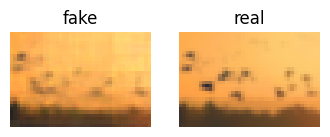

it scale 6:  80%|████████  | 1600/2000 [02:53<00:41,  9.64it/s]

[scale 6 | it 1600]  Lips ≈ 1.44
[scale 6 | it 1600]  LR = 5.00e-05


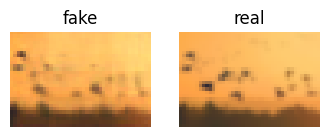

it scale 6:  90%|█████████ | 1800/2000 [03:15<00:21,  9.37it/s]

[scale 6 | it 1800]  Lips ≈ 1.38
[scale 6 | it 1800]  LR = 5.00e-05


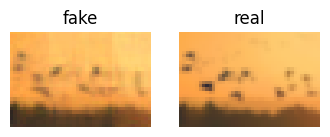

it scale 6: 100%|█████████▉| 1999/2000 [03:37<00:00,  9.33it/s]

[scale 6 | it 1999]  Lips ≈ 1.38
[scale 6 | it 1999]  LR = 5.00e-05


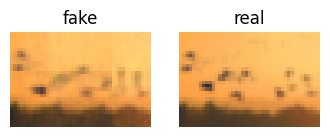

[init] copied weights from scale 6 → 5


it scale 5:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 5 | it 0]  Lips ≈ 1.24
[scale 5 | it 0]  LR = 5.00e-04


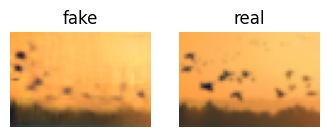

it scale 5:  10%|█         | 200/2000 [00:21<03:12,  9.36it/s]

[scale 5 | it 200]  Lips ≈ 1.23
[scale 5 | it 200]  LR = 5.00e-04


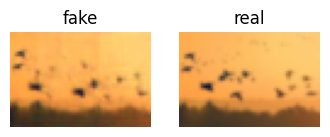

it scale 5:  20%|██        | 400/2000 [00:43<02:58,  8.96it/s]

[scale 5 | it 400]  Lips ≈ 1.14
[scale 5 | it 400]  LR = 5.00e-04


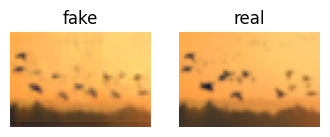

it scale 5:  30%|███       | 600/2000 [01:05<02:34,  9.08it/s]

[scale 5 | it 600]  Lips ≈ 1.30
[scale 5 | it 600]  LR = 5.00e-04


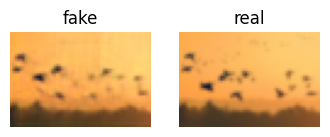

it scale 5:  40%|████      | 800/2000 [01:28<02:19,  8.57it/s]

[scale 5 | it 800]  Lips ≈ 1.43
[scale 5 | it 800]  LR = 5.00e-04


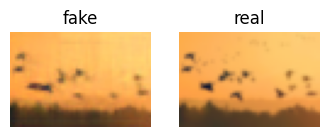

it scale 5:  50%|█████     | 1000/2000 [01:50<01:56,  8.60it/s]

[scale 5 | it 1000]  Lips ≈ 1.27
[scale 5 | it 1000]  LR = 5.00e-04


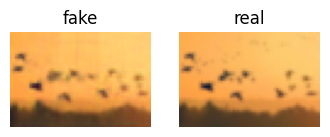

it scale 5:  60%|██████    | 1200/2000 [02:14<01:38,  8.16it/s]

[scale 5 | it 1200]  Lips ≈ 1.40
[scale 5 | it 1200]  LR = 5.00e-04


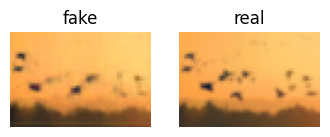

it scale 5:  70%|███████   | 1400/2000 [02:38<01:12,  8.27it/s]

[scale 5 | it 1400]  Lips ≈ 1.29
[scale 5 | it 1400]  LR = 5.00e-04


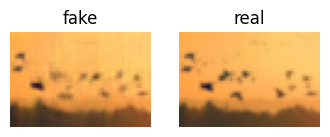

it scale 5:  80%|████████  | 1600/2000 [03:03<00:49,  8.15it/s]

[scale 5 | it 1600]  Lips ≈ 1.46
[scale 5 | it 1600]  LR = 5.00e-05


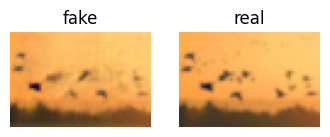

it scale 5:  90%|█████████ | 1800/2000 [03:27<00:24,  8.19it/s]

[scale 5 | it 1800]  Lips ≈ 1.13
[scale 5 | it 1800]  LR = 5.00e-05


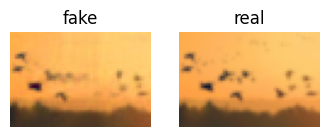

it scale 5: 100%|█████████▉| 1999/2000 [03:52<00:00,  8.07it/s]

[scale 5 | it 1999]  Lips ≈ 1.40
[scale 5 | it 1999]  LR = 5.00e-05


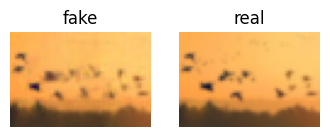

[init] copied weights from scale 5 → 4


it scale 4:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 4 | it 0]  Lips ≈ 1.24
[scale 4 | it 0]  LR = 5.00e-04


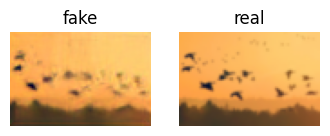

it scale 4:  10%|█         | 200/2000 [00:35<05:15,  5.71it/s]

[scale 4 | it 200]  Lips ≈ 1.20
[scale 4 | it 200]  LR = 5.00e-04


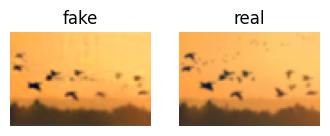

it scale 4:  20%|██        | 400/2000 [01:10<04:38,  5.74it/s]

[scale 4 | it 400]  Lips ≈ 1.66
[scale 4 | it 400]  LR = 5.00e-04


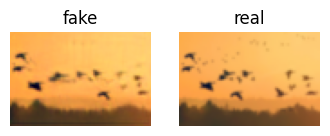

it scale 4:  30%|███       | 600/2000 [01:45<04:05,  5.70it/s]

[scale 4 | it 600]  Lips ≈ 1.29
[scale 4 | it 600]  LR = 5.00e-04


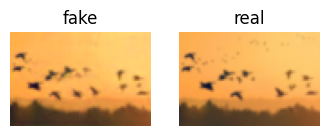

it scale 4:  40%|████      | 800/2000 [02:20<03:32,  5.66it/s]

[scale 4 | it 800]  Lips ≈ 1.35
[scale 4 | it 800]  LR = 5.00e-04


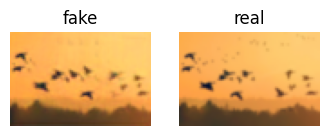

it scale 4:  50%|█████     | 1000/2000 [02:55<02:56,  5.68it/s]

[scale 4 | it 1000]  Lips ≈ 1.46
[scale 4 | it 1000]  LR = 5.00e-04


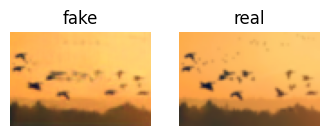

it scale 4:  60%|██████    | 1200/2000 [03:31<02:29,  5.34it/s]

[scale 4 | it 1200]  Lips ≈ 1.43
[scale 4 | it 1200]  LR = 5.00e-04


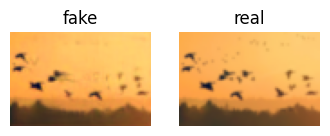

it scale 4:  70%|███████   | 1400/2000 [04:08<01:50,  5.42it/s]

[scale 4 | it 1400]  Lips ≈ 1.07
[scale 4 | it 1400]  LR = 5.00e-04


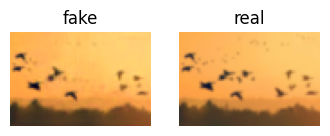

it scale 4:  80%|████████  | 1600/2000 [04:43<01:08,  5.80it/s]

[scale 4 | it 1600]  Lips ≈ 1.33
[scale 4 | it 1600]  LR = 5.00e-05


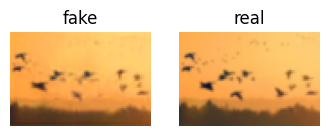

it scale 4:  90%|█████████ | 1800/2000 [05:18<00:34,  5.76it/s]

[scale 4 | it 1800]  Lips ≈ 1.41
[scale 4 | it 1800]  LR = 5.00e-05


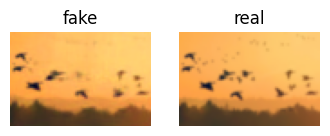

it scale 4: 100%|█████████▉| 1999/2000 [05:54<00:00,  5.29it/s]

[scale 4 | it 1999]  Lips ≈ 1.44
[scale 4 | it 1999]  LR = 5.00e-05


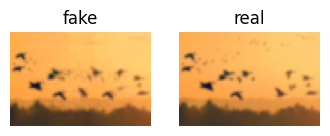

[init] copied weights from scale 4 → 3


it scale 3:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 3 | it 0]  Lips ≈ 1.26
[scale 3 | it 0]  LR = 5.00e-04


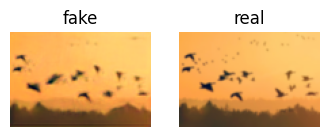

it scale 3:  10%|█         | 200/2000 [00:50<07:25,  4.04it/s]

[scale 3 | it 200]  Lips ≈ 1.22
[scale 3 | it 200]  LR = 5.00e-04


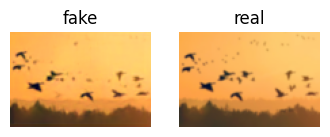

it scale 3:  20%|██        | 400/2000 [01:39<06:40,  3.99it/s]

[scale 3 | it 400]  Lips ≈ 1.04
[scale 3 | it 400]  LR = 5.00e-04


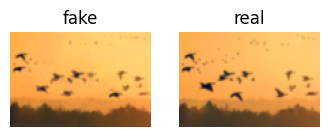

it scale 3:  30%|███       | 600/2000 [02:29<05:50,  3.99it/s]

[scale 3 | it 600]  Lips ≈ 1.49
[scale 3 | it 600]  LR = 5.00e-04


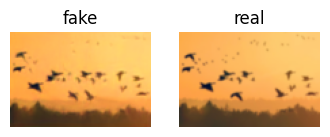

it scale 3:  40%|████      | 800/2000 [03:19<04:52,  4.10it/s]

[scale 3 | it 800]  Lips ≈ 1.40
[scale 3 | it 800]  LR = 5.00e-04


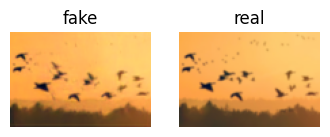

it scale 3:  50%|█████     | 1000/2000 [04:08<04:09,  4.01it/s]

[scale 3 | it 1000]  Lips ≈ 1.49
[scale 3 | it 1000]  LR = 5.00e-04


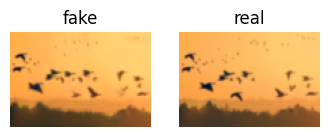

it scale 3:  60%|██████    | 1200/2000 [04:59<03:20,  3.99it/s]

[scale 3 | it 1200]  Lips ≈ 1.56
[scale 3 | it 1200]  LR = 5.00e-04


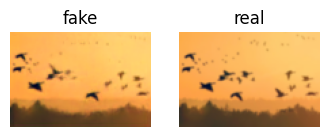

it scale 3:  70%|███████   | 1400/2000 [05:58<02:31,  3.96it/s]

[scale 3 | it 1400]  Lips ≈ 1.00
[scale 3 | it 1400]  LR = 5.00e-04


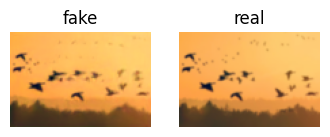

it scale 3:  80%|████████  | 1600/2000 [06:50<01:39,  4.01it/s]

[scale 3 | it 1600]  Lips ≈ 1.09
[scale 3 | it 1600]  LR = 5.00e-05


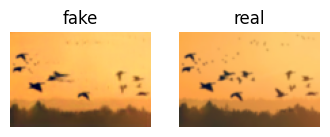

it scale 3:  90%|█████████ | 1800/2000 [07:40<00:51,  3.88it/s]

[scale 3 | it 1800]  Lips ≈ 1.40
[scale 3 | it 1800]  LR = 5.00e-05


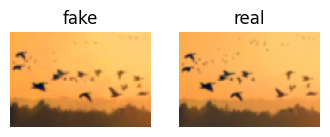

it scale 3: 100%|█████████▉| 1999/2000 [08:32<00:00,  3.74it/s]

[scale 3 | it 1999]  Lips ≈ 1.38
[scale 3 | it 1999]  LR = 5.00e-05


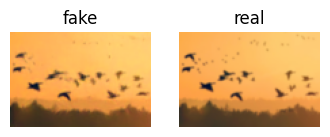

it scale 2:   0%|          | 0/2000 [00:00<?, ?it/s]           

[scale 2 | it 0]  Lips ≈ 0.02
[scale 2 | it 0]  LR = 5.00e-04


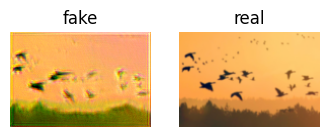

it scale 2:  10%|█         | 200/2000 [00:49<07:33,  3.97it/s]

[scale 2 | it 200]  Lips ≈ 1.00
[scale 2 | it 200]  LR = 5.00e-04


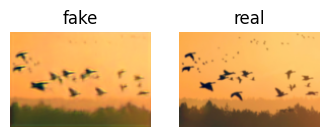

it scale 2:  20%|██        | 400/2000 [01:38<06:23,  4.17it/s]

[scale 2 | it 400]  Lips ≈ 0.98
[scale 2 | it 400]  LR = 5.00e-04


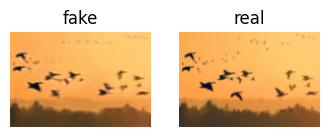

it scale 2:  30%|███       | 600/2000 [02:27<05:47,  4.02it/s]

[scale 2 | it 600]  Lips ≈ 1.01
[scale 2 | it 600]  LR = 5.00e-04


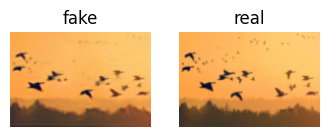

it scale 2:  40%|████      | 800/2000 [03:17<04:28,  4.46it/s]

[scale 2 | it 800]  Lips ≈ 1.35
[scale 2 | it 800]  LR = 5.00e-04


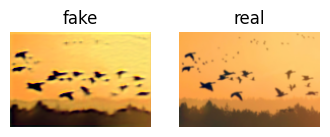

it scale 2:  50%|█████     | 1000/2000 [04:06<04:12,  3.95it/s]

[scale 2 | it 1000]  Lips ≈ 0.89
[scale 2 | it 1000]  LR = 5.00e-04


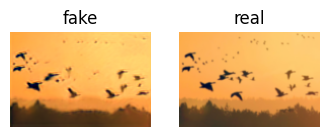

it scale 2:  60%|██████    | 1200/2000 [04:56<03:25,  3.88it/s]

[scale 2 | it 1200]  Lips ≈ 1.09
[scale 2 | it 1200]  LR = 5.00e-04


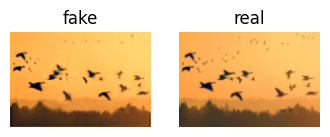

it scale 2:  70%|███████   | 1400/2000 [05:46<02:34,  3.87it/s]

[scale 2 | it 1400]  Lips ≈ 0.99
[scale 2 | it 1400]  LR = 5.00e-04


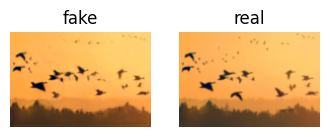

it scale 2:  80%|████████  | 1600/2000 [06:37<01:42,  3.90it/s]

[scale 2 | it 1600]  Lips ≈ 0.97
[scale 2 | it 1600]  LR = 5.00e-05


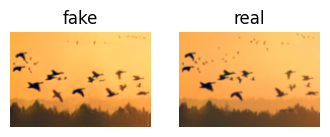

it scale 2:  90%|█████████ | 1800/2000 [07:27<00:51,  3.89it/s]

[scale 2 | it 1800]  Lips ≈ 1.06
[scale 2 | it 1800]  LR = 5.00e-05


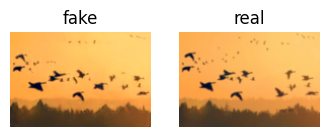

it scale 2: 100%|█████████▉| 1999/2000 [08:21<00:00,  2.24it/s]

[scale 2 | it 1999]  Lips ≈ 1.05
[scale 2 | it 1999]  LR = 5.00e-05


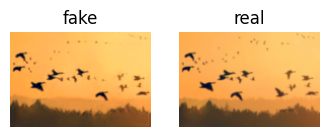

[init] copied weights from scale 2 → 1


it scale 1:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 1 | it 0]  Lips ≈ 1.01
[scale 1 | it 0]  LR = 5.00e-04


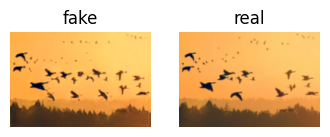

it scale 1:  10%|█         | 200/2000 [01:19<10:47,  2.78it/s]

[scale 1 | it 200]  Lips ≈ 1.21
[scale 1 | it 200]  LR = 5.00e-04


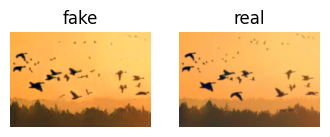

it scale 1:  20%|██        | 400/2000 [02:31<09:32,  2.80it/s]

[scale 1 | it 400]  Lips ≈ 1.08
[scale 1 | it 400]  LR = 5.00e-04


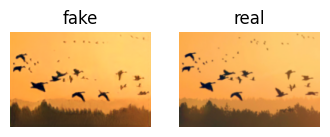

it scale 1:  30%|███       | 600/2000 [03:42<08:17,  2.81it/s]

[scale 1 | it 600]  Lips ≈ 1.20
[scale 1 | it 600]  LR = 5.00e-04


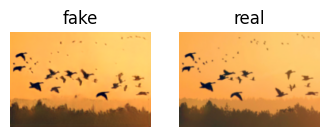

it scale 1:  40%|████      | 800/2000 [04:54<07:08,  2.80it/s]

[scale 1 | it 800]  Lips ≈ 1.10
[scale 1 | it 800]  LR = 5.00e-04


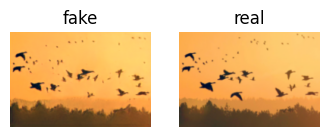

it scale 1:  50%|█████     | 1000/2000 [06:06<05:58,  2.79it/s]

[scale 1 | it 1000]  Lips ≈ 1.10
[scale 1 | it 1000]  LR = 5.00e-04


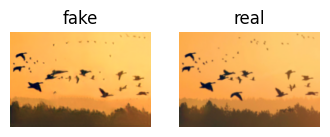

it scale 1:  60%|██████    | 1200/2000 [07:17<04:47,  2.78it/s]

[scale 1 | it 1200]  Lips ≈ 1.20
[scale 1 | it 1200]  LR = 5.00e-04


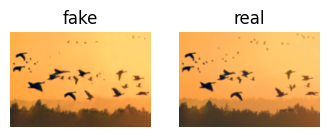

it scale 1:  70%|███████   | 1400/2000 [08:30<03:46,  2.65it/s]

[scale 1 | it 1400]  Lips ≈ 1.20
[scale 1 | it 1400]  LR = 5.00e-04


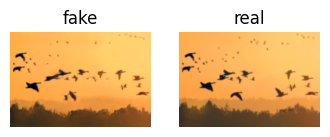

it scale 1:  80%|████████  | 1600/2000 [09:42<02:21,  2.83it/s]

[scale 1 | it 1600]  Lips ≈ 1.11
[scale 1 | it 1600]  LR = 5.00e-05


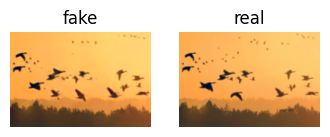

it scale 1:  90%|█████████ | 1800/2000 [10:53<01:11,  2.81it/s]

[scale 1 | it 1800]  Lips ≈ 1.40
[scale 1 | it 1800]  LR = 5.00e-05


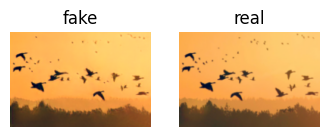

it scale 1: 100%|█████████▉| 1999/2000 [12:06<00:00,  2.82it/s]

[scale 1 | it 1999]  Lips ≈ 1.22
[scale 1 | it 1999]  LR = 5.00e-05


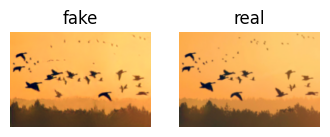

[init] copied weights from scale 1 → 0


it scale 0:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 0 | it 0]  Lips ≈ 0.92
[scale 0 | it 0]  LR = 5.00e-04


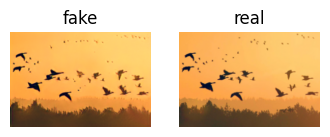

it scale 0:  10%|█         | 200/2000 [02:20<20:50,  1.44it/s]

[scale 0 | it 200]  Lips ≈ 1.19
[scale 0 | it 200]  LR = 5.00e-04


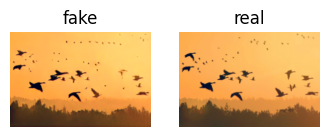

it scale 0:  20%|██        | 400/2000 [04:44<19:21,  1.38it/s]

[scale 0 | it 400]  Lips ≈ 1.32
[scale 0 | it 400]  LR = 5.00e-04


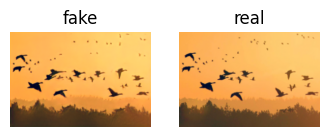

it scale 0:  30%|███       | 600/2000 [07:09<16:54,  1.38it/s]

[scale 0 | it 600]  Lips ≈ 1.41
[scale 0 | it 600]  LR = 5.00e-04


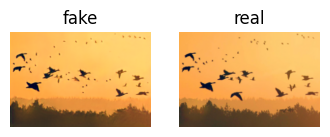

it scale 0:  40%|████      | 800/2000 [09:34<14:38,  1.37it/s]

[scale 0 | it 800]  Lips ≈ 1.26
[scale 0 | it 800]  LR = 5.00e-04


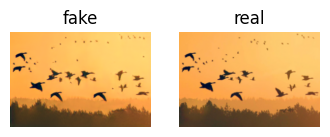

it scale 0:  50%|█████     | 1000/2000 [12:02<11:53,  1.40it/s]

[scale 0 | it 1000]  Lips ≈ 1.39
[scale 0 | it 1000]  LR = 5.00e-04


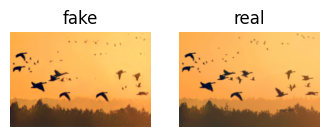

it scale 0:  60%|██████    | 1200/2000 [14:29<09:51,  1.35it/s]

[scale 0 | it 1200]  Lips ≈ 1.50
[scale 0 | it 1200]  LR = 5.00e-04


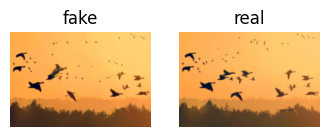

it scale 0:  70%|███████   | 1400/2000 [16:54<07:21,  1.36it/s]

[scale 0 | it 1400]  Lips ≈ 1.28
[scale 0 | it 1400]  LR = 5.00e-04


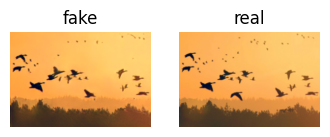

it scale 0:  80%|████████  | 1600/2000 [19:23<05:00,  1.33it/s]

[scale 0 | it 1600]  Lips ≈ 0.98
[scale 0 | it 1600]  LR = 5.00e-05


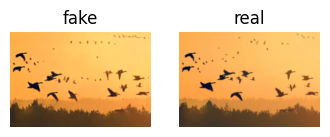

it scale 0:  90%|█████████ | 1800/2000 [21:42<02:19,  1.44it/s]

[scale 0 | it 1800]  Lips ≈ 1.71
[scale 0 | it 1800]  LR = 5.00e-05


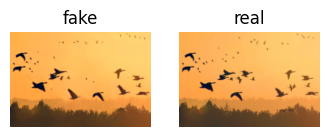

it scale 0: 100%|█████████▉| 1999/2000 [24:02<00:00,  1.43it/s]

[scale 0 | it 1999]  Lips ≈ 1.62
[scale 0 | it 1999]  LR = 5.00e-05


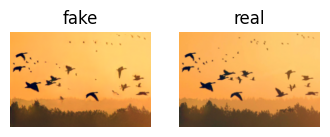

In [17]:
torch.random.manual_seed(0)

# params
lambda_gp    = 10
lr             = 5e-4 # celui du github
betas            = (0.5, 0.999) # pareil
n_Discriminator  = 5 # pif
n_Generator      = 2 # pif
iter_per_scale   = 2000 # github
alpha_rec      = 10 # gith
beta_sigma   = 0.1 # git
debug          = True
b          = 1  # batch size   
N = len(scales)


for G in Genarators:
    G.apply(weights_init)
for D in Discriminators:
    D.apply(weights_init)

# reset des optim.
optimizer_G, optimizer_D = [], []
for i in range(N):
    optimizer_G.append(optim.Adam(Genarators[i].parameters(), lr=lr, betas=betas))
    optimizer_D.append(optim.Adam(Discriminators[i].parameters(), lr=lr, betas=betas))

# --- LR schedulers -----------------------------------------------------------
# Each StepLR will keep the LR unchanged for 1 600 iterations, then multiply it
# by 0.1 once, and keep the new value for the remaining ~400 iterations.
scheduler_G, scheduler_D = [], []

step_size   = 1600          # when to trigger the decay
gamma       = 0.1            # multiplicative factor

for opt_G, opt_D in zip(optimizer_G, optimizer_D):
    scheduler_G.append(
        torch.optim.lr_scheduler.StepLR(opt_G, step_size=step_size, gamma=gamma)
    )
    scheduler_D.append(
        torch.optim.lr_scheduler.StepLR(opt_D, step_size=step_size, gamma=gamma)
    )


z_star   = torch.randn_like(scales[-1])               # bruit fixe
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(scales[-1]).to(device)]
       

@torch.no_grad()
def regenerate_prev(k):
    # k : res actuelle
    # retourne une nouvelle image avec le générateur précedent.
    # reprend la dernière image généré et rajoute du bruit puis upsample`
    if k == N-1:
        return torch.zeros_like(scales[k]).to(device)

    low_prev = gen_image[-1]                           
    z_prev   = torch.randn_like(low_prev) * sigma_n[k+1]
    low_fake = Genarators[k+1](z_prev + low_prev) + low_prev

    prev_img = F.interpolate(low_fake,
                             size=scales[k].shape[2:], 
                             mode='bilinear', align_corners=False)
    return prev_img

@torch.no_grad()
def regenerate_prev_full(k):
    """
    Reconstruit un prev_img pour l'échelle k en:
      +  partant d'une image nulle au coarse (N-1),
      + appliquant *tous* les G gelés (N-1 … k+1) avec nouveau bruit,
      +  upsamplant le résultat (k+1) → résolution de k.
    """
    if k == N-1:                                    # échelle coarse → zeros
        return torch.zeros_like(scales[k]).to(device)

    # scale la plus petite
    img = torch.zeros_like(scales[-1]).to(device)   
    z   = torch.randn_like(img) * sigma_n[N-1]
    img = Genarators[N-1](z)                       

    # on remonte le réseau
    for s in range(N-2, k, -1):                     
        img_up = F.interpolate(img,
                               size=scales[s].shape[2:],
                               mode='bilinear', align_corners=False)
        z      = torch.randn_like(img_up) * sigma_n[s]
        img    = Genarators[s](z + img_up) + img_up

    prev_img = F.interpolate(img,
                             size=scales[k].shape[2:],
                             mode='bilinear', align_corners=False)
    return prev_img

def lipconstant(D, x, y):
    
    b = x.size(0)
    if y.size(0) != b:
        raise ValueError("batch sizes differ")

    alpha = torch.rand((b,1,1,1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_(True)

    Di = D(interp).mean()                    # mean sinon ça me donnait des truc abbérant
    gradients = torch.autograd.grad(
        outputs=Di, inputs=interp,
        grad_outputs=torch.ones_like(Di),    
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    eps = 1e-12
    gradients_norm = torch.sqrt(gradients.flatten(1).pow(2).sum(1) + eps)
    return gradients_norm.mean()

# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1          
    Gk = Genarators[current_res].train()
    Dk = Discriminators[current_res].train()
    xk_real = scales[current_res].to(device)
    
    
    if current_res < N-1:                          
        G_prev = Genarators[current_res + 1]
        D_prev = Discriminators[current_res + 1]

        def same_channels(net_a, net_b):
            """return True if first conv out-channels match"""
            for m_a, m_b in zip(net_a.modules(), net_b.modules()):
                if isinstance(m_a, torch.nn.Conv2d):
                    return m_a.out_channels == m_b.out_channels
            return False

        if same_channels(Gk, G_prev):              
            Gk.load_state_dict(G_prev.state_dict(), strict=True)
            Dk.load_state_dict(D_prev.state_dict(), strict=True)
            if debug:
                print(f"[init] copied weights from scale {current_res+1} → {current_res}")

    # NB: from here on, use *Gk* / *Dk*; they already sit in the
    #     Genarators / Discriminators lists, so nothing else changes.
    Gk.train();  Dk.train()
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
    opt_D = optimizer_D[current_res]
    

# Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1],
                               size=xk_real.shape[2:], mode='bilinear', align_corners=False)

        # σ_n = β · RMSE((x_rec[n+1]↑), x_n) / RMSE(0, x_n) # formule trouvé je sais plus ou. 
        num   = F.mse_loss(up_rec, xk_real)             
        denom = F.mse_loss(torch.zeros_like(xk_real), xk_real)
        sigma_n[current_res] = beta_sigma * torch.sqrt(num / denom)   
    else:
        sigma_n[current_res] = torch.tensor(1, device=device)

    # itérations par scale
    for it in tqdm(range(iter_per_scale), desc=f"it scale {current_res}", leave=False):

        # prev_img tiré fraichement
        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res)

        # trainning discriminateur
        for _ in range(n_Discriminator):
            opt_D.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img

            loss_D = Dk(fake.detach()).mean() - Dk(xk_real).mean()

            # gradient penalty
            alpha = torch.rand(b,1,1,1,device=device)
            interp = (alpha*xk_real + (1-alpha)*fake.detach()).requires_grad_(True)
            grad_out = Dk(interp).mean()
            grad = torch.autograd.grad(grad_out, interp, torch.ones_like(grad_out),
                                       create_graph=True, retain_graph=True, only_inputs=True)[0]
            gp = lambda_gp * ((grad.flatten(1).norm(2,dim=1)-1)**2).mean()
            (loss_D + gp).backward()
            opt_D.step()

       

        for g_idx in range(n_Generator):
            opt_G.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img
            adv_G = -Dk(fake).mean()

            # ----- Reconstruction eq. 5 -----
            if current_res == N-1:                         # coarse
                rec_in = z_star                             # MOD (z_star)
                rec_out = Gk(rec_in)                       # pas de upsample
            else:                                          # n < N
                up_fixed = F.interpolate(x_rec[current_res+1],
                                          size=xk_real.shape[2:], mode='bilinear', align_corners=False)
                rec_in = up_fixed                          # MOD (bruit = 0)
                rec_out = Gk(rec_in) + up_fixed            # MOD

            Lrec = F.mse_loss(rec_out, xk_real)
            (adv_G + alpha_rec * Lrec).backward()
            opt_G.step()
        
        # ---- advance LR scheduler *once* for this outer iteration
        scheduler_D[current_res].step()
        scheduler_G[current_res].step()
        
        # logs
        if debug and (it % 200 == 0 or it==iter_per_scale-1):
            # pas de torch.no_grad() ici : on a besoin du backward dans lipconstant
            lips = lipconstant(Dk, fake.detach(), xk_real)
            print(f"[scale {current_res} | it {it}]  Lips ≈ {lips:.2f}")
            current_lr = opt_G.param_groups[0]['lr']
            print(f"[scale {current_res} | it {it}]  LR = {current_lr:.2e}")

            with torch.no_grad():                     # on garde no_grad pour l’affichage
                plt.figure(figsize=(4,2))
                plt.subplot(1,2,1); plt.imshow(pil_from_minus1to1(fake[0].cpu())); plt.axis('off'); plt.title('fake')
                plt.subplot(1,2,2); plt.imshow(pil_from_minus1to1(xk_real[0].cpu()));        plt.axis('off'); plt.title('real')
                plt.show()
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        gen_image.append(fake.detach())
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star)                              # NEW (bruit fixe)
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 # NEW (bruit 0)
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)


SAVING GENERATORS AND OR LOADING OTHERS

In [ ]:
# ==== SAVE GENERATORS ========================================================
import os, datetime, torch, json

model_name = "basic" 
image_name = "oiseau"                   
model_dir  = os.path.join("models", image_name,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")    # ← chemin pour z_star

if os.path.exists(model_dir):
    print(f"ATTENTION : Un modèle nommé '{model_name}' existe déjà dans '{model_dir}'.")
    print("   → Choisis un autre nom pour ne pas l'écraser.")
else:
    os.makedirs(model_dir, exist_ok=True)

    # 1) sauvegarde des poids : liste d'état (un par G_k)
    torch.save([G.state_dict() for G in Genarators], weights_fp)

    # 2) petit fichier description (texte lisible)
    description = {
        "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
        "N"              : N,
        "lambda_gp"      : lambda_gp,
        "r"                 : float(r),
        "lr"             : lr,
        "betas"          : betas,
        "n_Discriminator": n_Discriminator,
        "n_Generator"    : n_Generator,
        "iter_per_scale" : iter_per_scale,
        "alpha_rec"      : alpha_rec,
        "beta_sigma"     : beta_sigma,
        "comment"        : "Sin Gan avec poids classique comme dans le papier sauf le padding",
    }
    with open(descr_fp, "w", encoding="utf-8") as f:
        for k, v in description.items():
            f.write(f"{k}: {v}\n")

    # 3) sauvegarde de la liste sigma_n
    sigma_list = []
    for s in sigma_n:
        # si s est un tensor scalaire, on fait s.item(), sinon on lève une erreur
        if torch.is_tensor(s):
            sigma_list.append(s.item())
        else:
            sigma_list.append(float(s))
    with open(sigma_fp, "w", encoding="utf-8") as f:
        json.dump(sigma_list, f)


    # 4) génération et sauvegarde de z_star
    #    remplace (h, w) par la forme souhaitée
    torch.save(z_star, zstar_fp)

    print(f"Générateurs sauvegardés     -> {weights_fp}")
    print(f"Description créée           -> {descr_fp}")
    print(f"sigma_n sauvegardé          -> {sigma_fp}")
    print(f"z_star sauvegardé           -> {zstar_fp}")


Générateurs sauvegardés     -> models/oiseau/basic/generators.pt
Description créée           -> models/oiseau/basic/Description.txt
sigma_n sauvegardé          -> models/oiseau/basic/sigma_n.json
z_star sauvegardé           -> models/oiseau/basic/z_star.pt


In [22]:
# ===================== LOAD A CHECKPOINT, WHATEVER IS IN MEMORY =====================
import os, torch
import json  # pour sigma_n

# --- (1) nom du modèle à charger -----------------------------------------------------
image_name = "oiseau"
model_name = "basic"
model_dir  = os.path.join("models",image_name ,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")  

if not os.path.exists(weights_fp):
    raise FileNotFoundError(f"Impossible de trouver le fichier : {weights_fp}")

# --- (2) on lit la liste de state_dict ----------------------------------------------
state_list = torch.load(weights_fp, map_location="cpu")
print(f"💾  {len(state_list)} générateurs trouvés dans le checkpoint")

# (facultatif) on affiche le petit fichier description
if os.path.isfile(descr_fp):
    print("─── Description.txt ───")
    with open(descr_fp, encoding="utf-8") as f:
        print(f.read().strip())
    print("────────────────────────\n")

# --- (2bis) on charge la liste sigma_n ----------------------------------------------
if os.path.isfile(sigma_fp):
    with open(sigma_fp, "r", encoding="utf-8") as f:
        loaded_sigma_n = json.load(f)
    print(f"sigma_n chargé ({len(loaded_sigma_n)} éléments) → 'loaded_sigma_n'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier sigma_n : {sigma_fp}")

# --- (2ter) on charge z_star -------------------------------------------------------
if os.path.isfile(zstar_fp):
    loaded_z_star = torch.load(zstar_fp, map_location="cpu")
    print(f"z_star chargé de taille {tuple(loaded_z_star.shape)} → 'loaded_z_star'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier z_star : {zstar_fp}")

# --- (3) fonction helper : recrée un Generator adapté au state_dict -----------------
def build_generator_from_state(sd, device="cpu"):
    for key in sd.keys():
        if key.endswith(".weight") and sd[key].dim() == 4:
            n_hidden = sd[key].shape[0]
            break
    else:
        raise KeyError("Impossible d'inférer n_hidden depuis le state_dict.")
    G = Generator(n_hidden).to(device)
    G.load_state_dict(sd, strict=True)
    G.eval()
    for p in G.parameters():
        p.requires_grad_(False)
    return G

# --- (4) on construit la liste des générateurs chargés ------------------------------
device = torch.device("mps" if torch.mps.is_available() else "cpu")
loaded_generators = [build_generator_from_state(sd, device=device) for sd in state_list]

print(f"{len(loaded_generators)} générateurs instanciés → 'loaded_generators'")


💾  8 générateurs trouvés dans le checkpoint
─── Description.txt ───
date: 2025-05-30T16:14:07
N: 8
lambda_gp: 10
r: 1
lr: 0.0005
betas: (0.5, 0.999)
n_Discriminator: 5
n_Generator: 2
iter_per_scale: 2000
alpha_rec: 10
beta_sigma: 0.1
comment: Sin Gan avec poids classique comme dans le papier sauf le padding
────────────────────────

sigma_n chargé (8 éléments) → 'loaded_sigma_n'
z_star chargé de taille (1, 3, 21, 32) → 'loaded_z_star'
8 générateurs instanciés → 'loaded_generators'


In [23]:
@torch.no_grad()
def generate_multiscale(start_scale: int = N - 1,Generators = Genarators):
    """
    start_scale = 0  → on ne renouvelle le bruit qu’à la fine scale
    start_scale = N-1→ on renouvelle le bruit à toutes les échelles
    """
    # Génération totale
    if start_scale == N-1 : 
        h, w = scales[-1].shape[2:]
        gen_image = [torch.zeros((1, 3, h, w), device=device)]

         # 2. on remonte coarse → fine
        for i in range(N):
            k = N - 1 - i                    
        
            prev = gen_image[-1]
            if prev.shape[2:] != scales[k].shape[2:]:
                prev = F.interpolate(prev, size=scales[k].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[k]
            

            x_k = Generators[k](z + prev) + prev
            gen_image.append(x_k)

        

    else : 
        low = scales[start_scale+1] 
        up = F.interpolate(low, size=scales[start_scale].shape[2:],
                                    mode='bilinear', align_corners=False)
        gen_image = [up]

         # 2. on remonte coarse → fine
        for scale in range(start_scale,-1,-1):
                            
            prev = gen_image[-1]
            if prev.shape[2:] != scales[scale].shape[2:]:
                prev = F.interpolate(prev, size=scales[scale].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[scale]
            x_k = Genarators[scale](z + prev) + prev
            gen_image.append(x_k)

    
    return gen_image[1:]
        
    


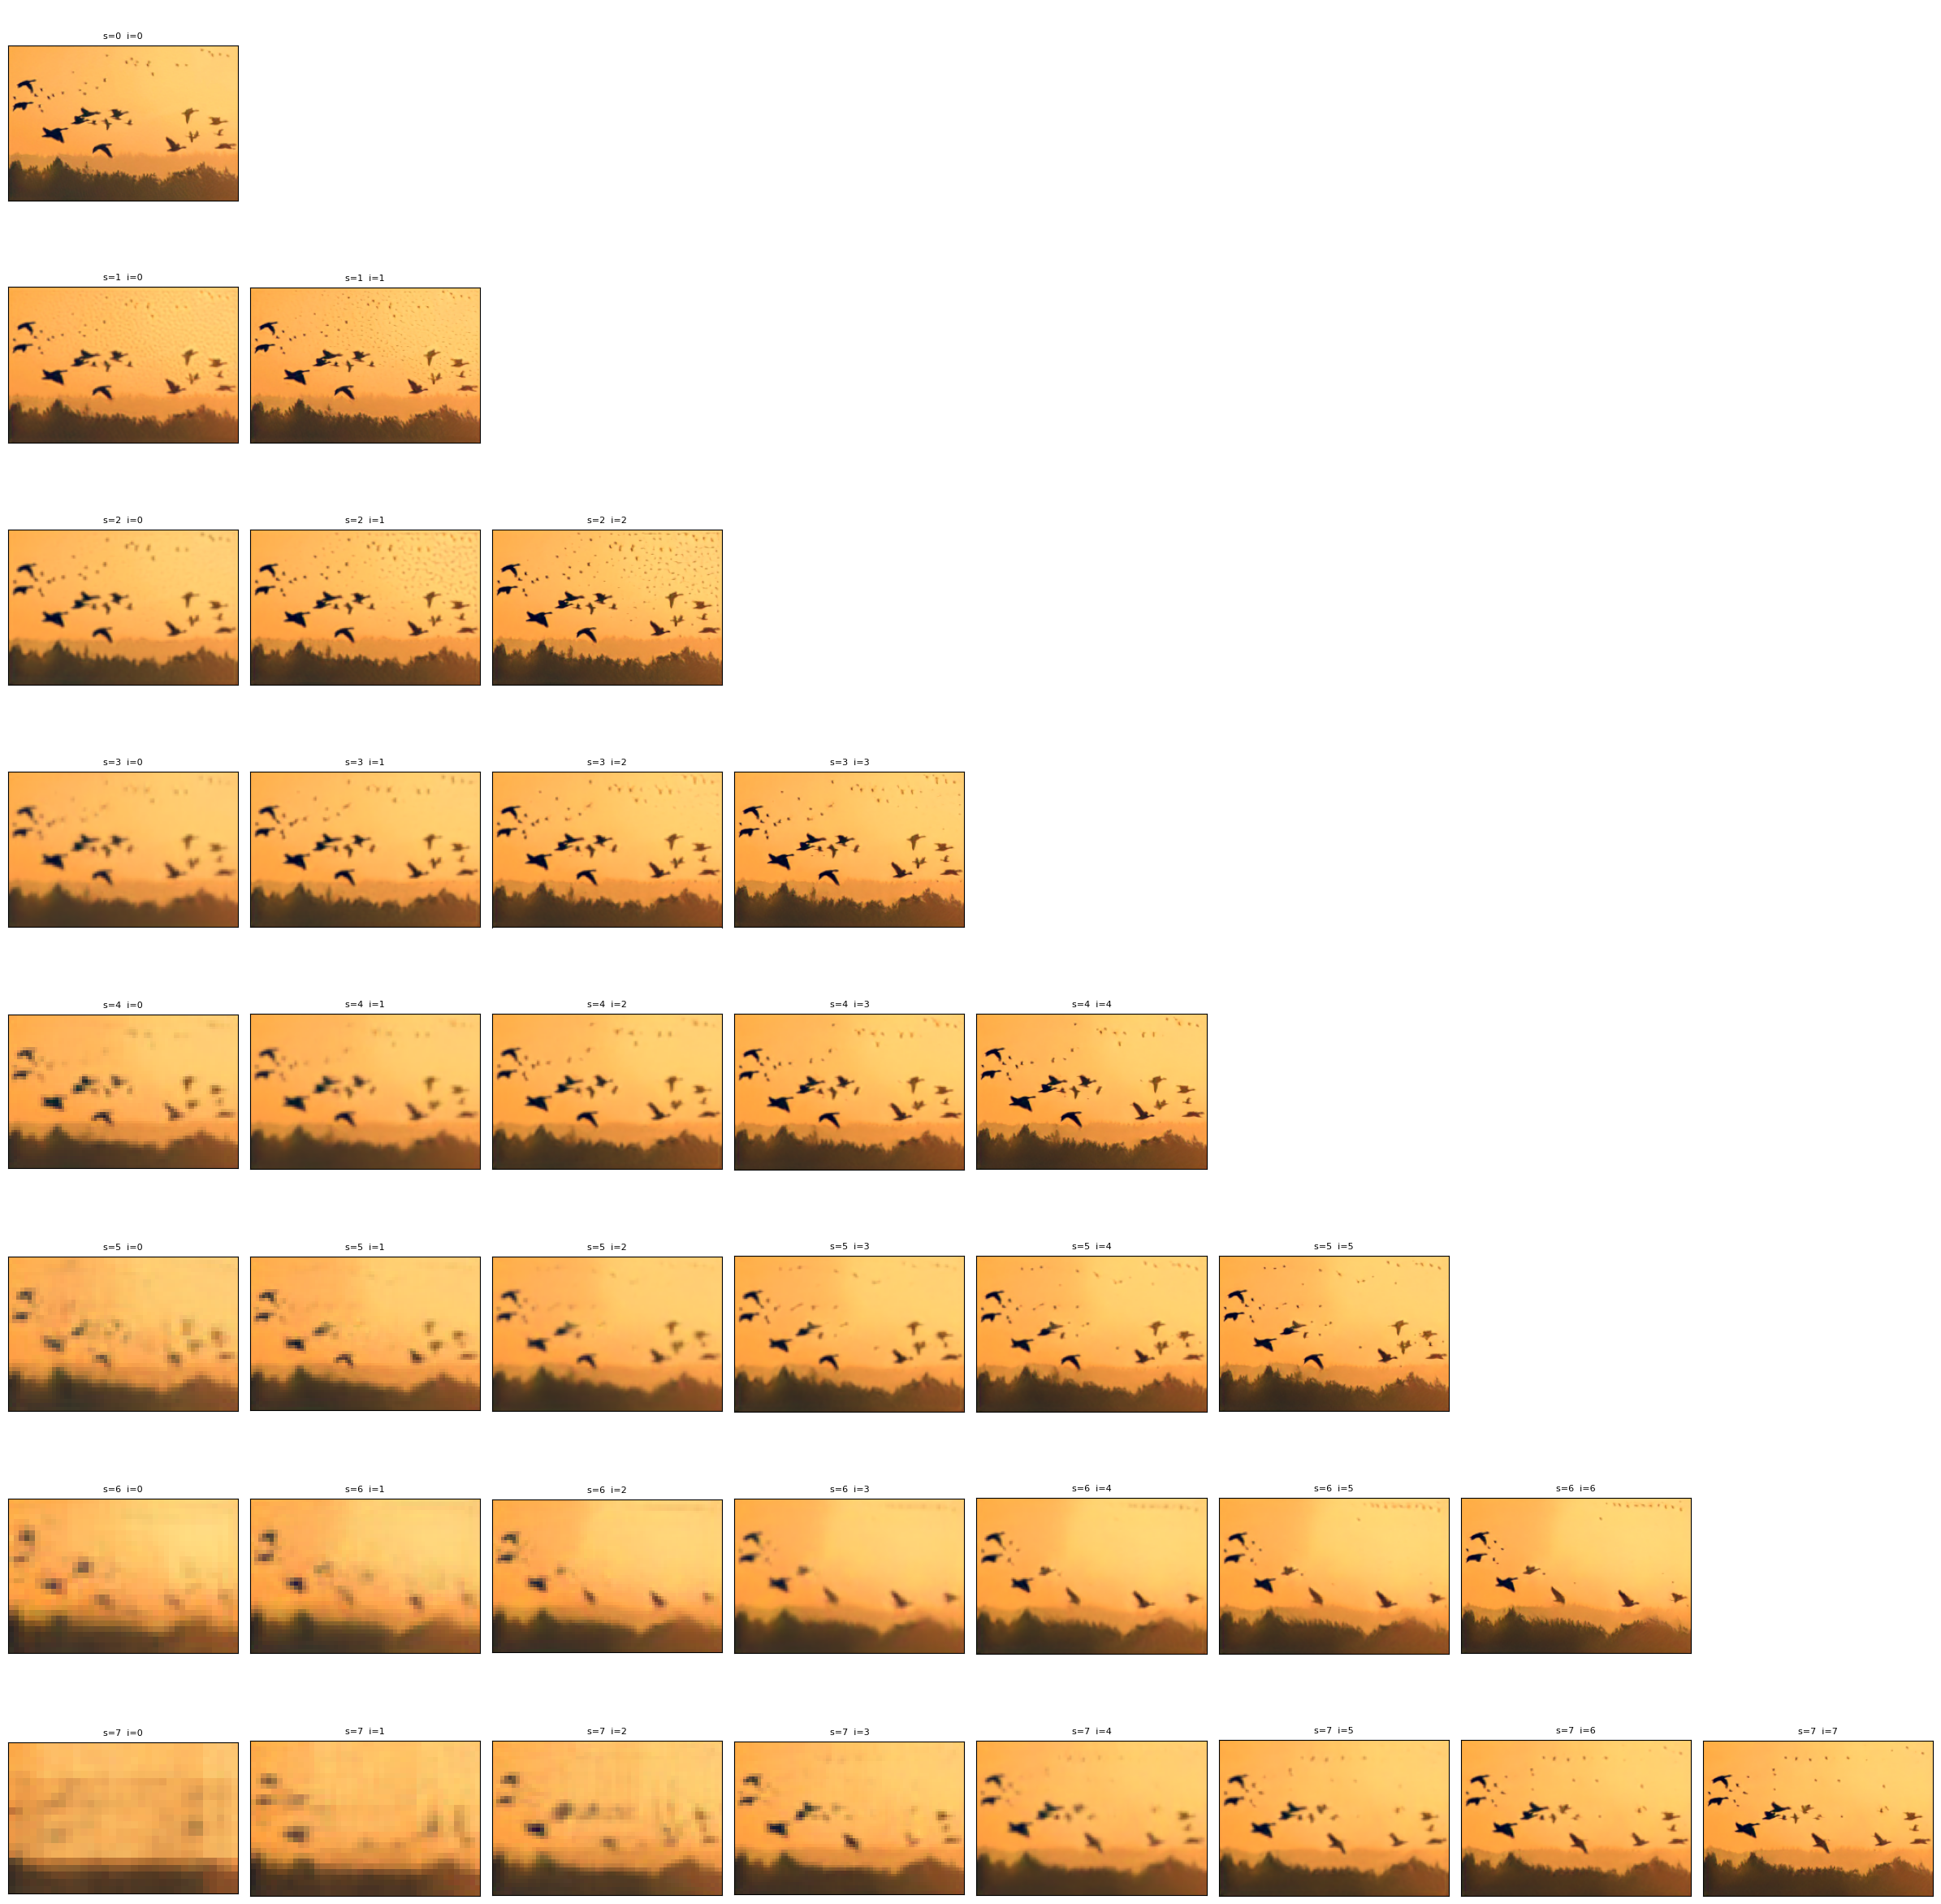

In [24]:
# 1. Collecter toutes les images pour connaître la taille de la grille
rows      = []                 # liste des listes d’images (Tensor)
max_cols  = 0
for s in range(N):
    imgs = generate_multiscale(start_scale=s,Generators=loaded_generators)   # list[Tensor]
    rows.append(imgs)
    max_cols = max(max_cols, len(imgs))

# 2. Créer la figure
cell = 3.0                     # taille (pouces) d’une cellule
fig_w, fig_h = cell * max_cols, cell * N
fig, axes = plt.subplots(N, max_cols, figsize=(fig_w, fig_h), squeeze=False)

# 3. Remplir le tableau
for r, (s, imgs) in enumerate(zip(range(N), rows)):
    for c in range(max_cols):
        ax = axes[r, c]

        if c < len(imgs):
            img_pil = pil_from_minus1to1(imgs[c].cpu().squeeze())
            
            ax.imshow(img_pil)
            ax.set_title(f"s={s}  i={c}", fontsize=8)
        else:
            ax.axis('off')          # cellule vide

        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

saved → outputs/gen_20250530_162310_1.png
saved → outputs/gen_20250530_162310_2.png
saved → outputs/gen_20250530_162310_3.png
saved → outputs/gen_20250530_162310_4.png
saved → outputs/gen_20250530_162310_5.png
saved → outputs/gen_20250530_162310_6.png
saved → outputs/gen_20250530_162310_7.png
saved → outputs/gen_20250530_162310_8.png


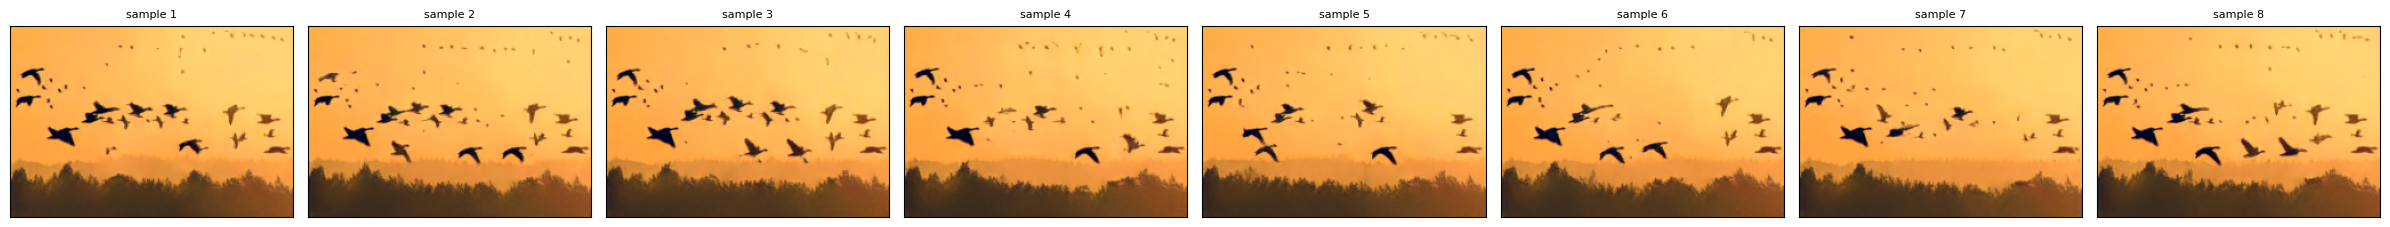

In [ ]:
import torchvision.utils as vutils
import os, time

# dossier de sortie
out_dir = "outputs/trash"
os.makedirs(out_dir, exist_ok=True)

# Nombre de générations
K = 8
final_imgs = []
for k in range(K):
    imgs = generate_multiscale(start_scale=N-1,Generators=loaded_generators)
    final_imgs.append(imgs[-1].cpu().squeeze())      # dernière image

# affichage + sauvegarde
cell = 3.0
fig, axes = plt.subplots(1, K, figsize=(cell*K, cell), squeeze=False)

for idx, (ax, img) in enumerate(zip(axes[0], final_imgs), 1):
    # plot
    ax.imshow(pil_from_minus1to1(img))
    ax.set_title(f"sample {idx}", fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

    # sauvegarde
    img_01 = ((img.clamp(-1, 1) + 1) / 2)            # [-1,1] → [0,1]
    filename = os.path.join(
        out_dir, f"gen_{time.strftime('%Y%m%d_%H%M%S')}_{idx}.png"
    )
    vutils.save_image(img_01, filename)
    print(f"saved → {filename}")

plt.tight_layout()
plt.show()


Reconstruction de XREC

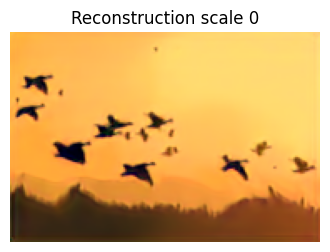

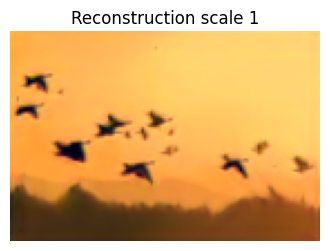

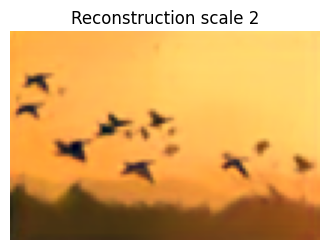

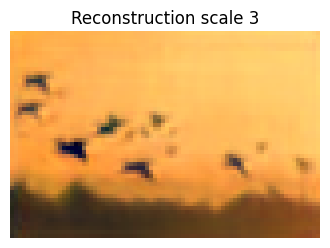

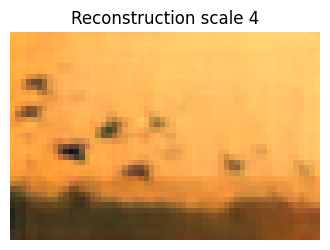

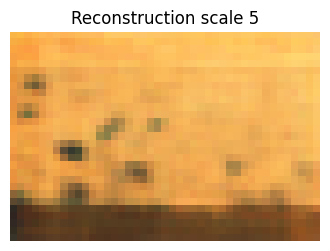

In [17]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec, scales):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:],scales)